In [1]:
from collections import defaultdict
from datetime import datetime
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

USERS_DATA_FILE = os.path.join("..", "data", "u.data")
ITEMS_DATA_FILE = os.path.join("..", "data", "u.item")

N_USERS, N_MOVIES = 943, 1682

users = pd.read_csv(USERS_DATA_FILE,
                    header = None,
                    sep = "\t",
                    names = ["user", "movie", "rating", "timestamp"],
                    dtype = {"user": int,
                             "movie": int,
                             "rating": int,
                             "timestamp": int})

users.timestamp = pd.to_datetime(users.timestamp, unit = "s")

genres = ["Unknown_genre", "Action", "Adventure", "Animation", "Children", "Comedy", "Crime",
          "Documentary", "Drama", "Fantasy", "Film_Noir", "Horror", "Musical",
          "Mystery", "Romance", "Sci_Fi", "Thriller", "War", "Western"]

column_names = ["movie_id", "movie_title", "video_release", "empty", "URL"] + genres

items = pd.read_csv(ITEMS_DATA_FILE,
            sep = "|",
            #index_col = False,
            encoding = "latin-1",
            header = None,
            names = column_names)

items = items.drop(columns=["empty"])

items[['movie_title', 'year']] = items['movie_title'].str.extract(r'^(.*)\s\((\d{4})\)$')
items.year = items.year.astype(float)

# Create 2 data structures for the data (dictionary-based and array-based)
data = defaultdict(dict)
data_filled = np.full((N_USERS, N_MOVIES),
                      np.nan)

with open(USERS_DATA_FILE, newline='', encoding='utf-8') as file:
    for line in file:
        fields = line.strip().split("\t")
        user_data = data[int(fields[0])]
        user_data[int(fields[1])] = int(fields[2])

        data_filled[int(fields[0]) - 1, int(fields[1]) - 1] = int(fields[2])

data_filled_zeros = np.nan_to_num(data_filled)
data_filled_zeros_normed = data_filled_zeros - data_filled_zeros.mean(axis = 1)[:, None]

# Create row averages for movies rated
user_means = dict()
data_normed = defaultdict(dict)
for user in data.keys():
    user_ratings = data[user].values()
    if len(user_ratings) > 0:
        user_means[user] = sum(user_ratings) / len(user_ratings)
    else:
        user_means[user] = 0
    for movie in data[user].keys():
        data_normed[user][movie] = data[user][movie] - user_means[user]

## A few additional visualizations
In my previous submission I did the main visualizations that I would initially do on a dataset. I've generated a few additional (though not as informative) visualizations here on the timestamp data.
### Ratings by day of week
It's surprising (at least to me) that users most frequently rated movies on Wednesdays.

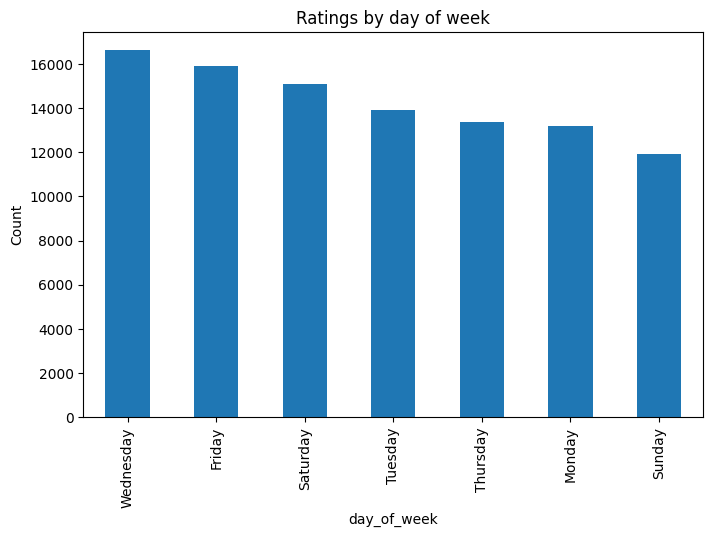

In [2]:
users["day_of_week"] = users['timestamp'].dt.day_name()

counts = users["day_of_week"].value_counts()

plt.figure(figsize = (8, 5))
counts.plot(kind = "bar")
plt.title("Ratings by day of week")
plt.ylabel("Count")
plt.xticks(rotation = 90)
plt.show()

### Plot of number of ratings per movie
This plot illustrates the long-tail phenomenon, characteristic of many ratings distributions.

<BarContainer object of 1682 artists>

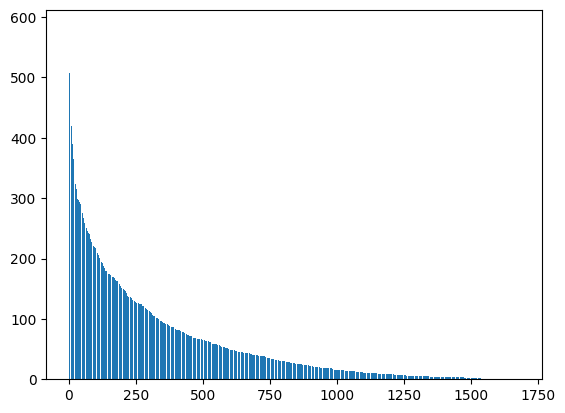

In [3]:
a = users.groupby("movie").size().sort_values(ascending = False)
plt.bar(range(0, len(a)), a.values)

## Import the data for the models
We import the data directly from `suprise` package to be able to work with it easier.

In [4]:
from surprise import Dataset

data = Dataset.load_builtin("ml-100k")

## Define helper functions for predictions

As noted in the function defintions, some of this code below as copied or adapted from the `Surprise` documentation. All other code was composed from scratch.

In [5]:
from collections import defaultdict

from surprise import SVD, accuracy
from sklearn.metrics import ndcg_score
from sklearn.metrics import roc_auc_score
from scipy import sparse

def auc_roc(predictions, threshold = 3.5):
    ratings = []
    preds = []
    for _, _, rating, pred, _ in predictions:
        ratings.append(1 if rating >= threshold else 0)
        preds.append(1 if pred >= threshold else 0)

    return roc_auc_score(ratings, preds)

def get_top_n(predictions, uuid, n=10):
    """
    Code was copied from: 
    https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-get-the-top-n-recommendations-for-each-user
    Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

def nDGC(preds, k = None):
    """
    Code adapted from:
    https://github.com/NicolasHug/Surprise/issues/339
    Calculates the normalized discounted cumulative gain over all recommendations
    """   
    uids = [int(p.uid) for p in preds]
    iids = [int(p.iid) for p in preds]
    r_uis = [p.r_ui for p in preds]
    ests = [p.est for p in preds]
    
    sparse_preds = sparse.coo_matrix((ests, (uids, iids)))
    sparse_vals = sparse.coo_matrix((r_uis, (uids, iids)))
    
    return ndcg_score(y_true = sparse_preds.toarray(),
                      y_score = sparse_vals.toarray(),
                      k = k)

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """
    Return precision and recall at k metrics for each user
    This code adapted from:
    https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-compute-precision-k-and-recall-k
    """
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

def avg_precision_recall_at_k(predictions, k = 10, threshold = 3.5):
    precisions, recalls = precision_recall_at_k(predictions, k, threshold)
    avg_precision = [item for _, item in precisions.items()]
    avg_precision = sum(avg_precision) / len(avg_precision)
    
    avg_recall = [item for _, item in recalls.items()]
    avg_recall = sum(avg_recall) / len(avg_recall)
    return (avg_precision, avg_recall)

## Run a 5-fold cross-validation
Run a 5-fold cross-validation of the SVD model and collect 6 measures for each run.

In [6]:
from surprise.model_selection import KFold

rmse_scores = []
mae = []
precision_k_scores = []
recall_k_scores = []
ndgc_scores = []
map_scores = []
auc_scores = []

kf = KFold(n_splits=5)
svd_algo = SVD()

for train, test in kf.split(data):
    svd_algo.fit(train)
    predictions = svd_algo.test(test)
    
    rmse_scores.append(accuracy.rmse(predictions, verbose = False))
    ndgc_scores.append(nDGC(predictions))

    precision, recall = avg_precision_recall_at_k(predictions)
    precision_k_scores.append(precision)
    recall_k_scores.append(recall)

    map, _ = avg_precision_recall_at_k(predictions, len(predictions))
    map_scores.append(map)

    auc_scores.append(auc_roc(predictions))

## Reporting metrics of SVD
The mean values of the 6 metrics are reported here.  A value of $K=10$ was used for Precision@K and Recall@K metrics.

In [7]:
print("RMSE: {} ± {}".format(np.mean(rmse_scores).round(4),
                            1.96 * np.std(rmse_scores).round(4)))
print("nDGC: {} ± {}".format(np.mean(ndgc_scores).round(4),
                            1.96 * np.std(ndgc_scores).round(4)))
print("Precision@10: {} ± {}".format(np.mean(precision_k_scores).round(4),
                            1.96 * np.std(precision_k_scores).round(4)))
print("Recall@10: {} ± {}".format(np.mean(recall_k_scores).round(4),
                            1.96 * np.std(recall_k_scores).round(4)))
print("Mean Average Precision: {} ± {}".format(np.mean(map_scores).round(4),
                            1.96 * np.std(map_scores).round(4)))
print("AUC of ROC: {} ± {}".format(np.mean(auc_scores).round(4),
                            1.96 * np.std(auc_scores).round(4)))

RMSE: 0.9364 ± 0.006272
nDGC: 0.9726 ± 0.00196
Precision@10: 0.6997 ± 0.010584
Recall@10: 0.5418 ± 0.010388
Mean Average Precision: 0.6722 ± 0.010192
AUC of ROC: 0.7062 ± 0.006076


## Generate a confusion matrix and recommendations for a user

Top 10 Movie Recommendations for User 5:
     rating  movie_id         movie_title
0  3.852769       189    Grand Day Out, A
1  3.768150       443          Birds, The
2  3.642154       433            Heathers
3  3.535728       234                Jaws
4  3.419790       176              Aliens
5  3.406489       183               Alien
6  3.365535       208  Young Frankenstein
7  3.360180       431          Highlander
8  3.285927       381    Muriel's Wedding
9  3.268821       447              Carrie


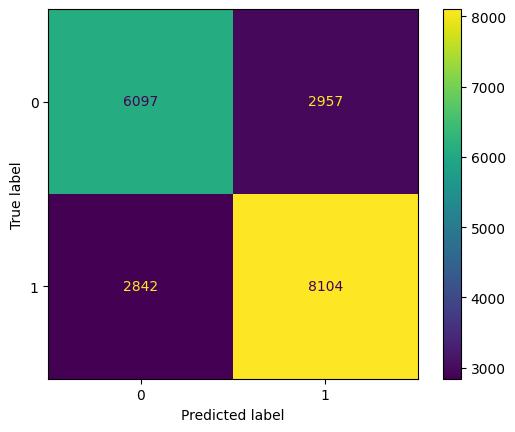

In [8]:
from surprise.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
  
# Split data into test and training
TEST_PROPORTION = .2
train, test = train_test_split(data,
                               test_size = TEST_PROPORTION)
    
# Train an SVD collaborative filtering algorithm and
# get predictions on the test
svd_algo = SVD()
svd_algo.fit(train)
predictions = svd_algo.test(test)

# Discretize the ratings into binary outcomes to create a confusion matrix
# Per example given in assignment: not_liked < 3.5  and liked >= 3.5
true_labels = [True if pred.r_ui >= 3.5 else False for pred in predictions]
predicted_labels = [True if pred.est >= 3.5 else False for pred in predictions]
conf_matrix = ConfusionMatrixDisplay(confusion_matrix(true_labels, predicted_labels)).plot()

user_to_query = "5"
top_10_movies = get_top_n(predictions, 10)[user_to_query]
top_10_movies = pd.DataFrame(top_10_movies)
top_10_movies.columns = ["movie", "rating"]
top_10_movies["movie"] = top_10_movies["movie"].astype(int)

print("Top 10 Movie Recommendations for User " + str(user_to_query) + ":")
print(pd.DataFrame(top_10_movies).merge(items,
                                        how="left",
                                        left_on="movie",
                                        right_on="movie_id").iloc[:,1:4])